# Classification with Titanic dataset

We build a Survival classification model and explain few predictions with SHAP.

Updated with SHAP v0.38.1

**To run this notebook with Sage Maker Studio, use Python 3 (SM JumpStart DS 1.0) kernel**

## Variables
Variables are both categorical and numerical:


* Survived is the target variable we are trying to predict (0 or 1):
    + 1 = Survived 
    + 0 = Not Survived

* Pclass (Passenger Class):
    + 1 = Upper Class
    + 2 = Middle Class
    + 3 = Lower Class

* Sex and Age are self-explanatory

* SibSp is the total number of the passengers' siblings and spouse

* Parch is the total number of the passengers' parents and children

* Fare is the passenger fare

* Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    + C = Cherbourg
    + Q = Queenstown
    + S = Southampton

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


X_orig, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_orig['pclass'] = X_orig['pclass'].astype('int')
X_orig.head()
#X_orig.tail(50)
#X_orig.shape

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


## Features
We will use 7 variables (3 categorical features, 4 numerical features) to predict if a passenger will survive.


In [2]:
categorical_columns = ['pclass', 'sex', 'embarked']
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

X = X_orig[categorical_columns + numerical_columns].copy()
X.head()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   int64   
 1   sex       1309 non-null   category
 2   embarked  1307 non-null   category
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   float64 
 5   parch     1309 non-null   float64 
 6   fare      1308 non-null   float64 
dtypes: category(2), float64(4), int64(1)
memory usage: 54.1 KB


## Features transformation
We fill NA values and convert categorical features to one hot encoding (with dummies value).
One hot encoding is optional here since we will use a tree based classifier.

In [3]:
#Replace na by median for numerical features
for c in numerical_columns:
    X[c] = X[c].fillna(X[c].median())
#Replace na by mode for categorical features
for c in categorical_columns:
    X[c] = X[c].astype('category')
    X[c] = X[c].fillna(X[c].mode().iloc[0])

In [4]:
#Build dummies dataframe for categorical vars
X_dum = pd.get_dummies(X[categorical_columns], prefix=categorical_columns, drop_first=True)
X_dum.head()

,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,0,0,0,0,1
1,0,0,1,0,1
2,0,0,0,0,1
3,0,0,1,0,1
4,0,0,0,0,1


In [5]:
#Replace categories by dummies
X = X.join(X_dum)
X = X.drop(columns=categorical_columns)
X.head()

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,29.0000,0.0,0.0,211.3375,0,0,0,0,1
1,0.9167,1.0,2.0,151.5500,0,0,1,0,1
2,2.0000,1.0,2.0,151.5500,0,0,0,0,1
3,30.0000,1.0,2.0,151.5500,0,0,1,0,1
4,25.0000,1.0,2.0,151.5500,0,0,0,0,1


In [6]:
features = X.columns
features

Index(['age', 'sibsp', 'parch', 'fare', 'pclass_2', 'pclass_3', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')

## Random Forest classifier
We build and train a Random Forest classifier with all the data

In [7]:
#Train a RandomForestClassifier with X and y
rf = RandomForestClassifier(n_estimators=100, random_state=0)
#rf.fit(X, y)
rf.fit(X.values, y.values) #Updated to clear scikitlearn warning

RandomForestClassifier(random_state=0)

In [8]:
#print("RF model accuracy: %0.3f" % rf.score(X, y))
print("RF model accuracy: %0.3f" % rf.score(X.values, y.values))
#print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF model accuracy: 0.966


Jack and Rose
==============

Now comes Jack and Rose!
We will evaluate the model with them.


![Jack and Rose](https://img.20mn.fr/OTHEAkuxRsabSyyULbWmkg/640x410_leonardo-dicaprio-kate-winslet-film-titanic.jpg)

In [9]:
# Jack & Rose data
personal_info = np.array([
    [17, 1, 1, 151.5, 0, 0, 0, 0, 1 ],
    [20, 0, 0, 9.5, 0, 1, 1, 0, 1 ],
    [20, 0, 0, 211.3, 0, 0, 1, 0, 1 ],
    [5, 0, 1, 9.5, 0, 1, 1, 0, 1 ]
    ])

df_test = pd.DataFrame(personal_info, index=['Rose','Jack','Jack_Rich','Jack_Boy'], columns=features)
X_test = df_test.copy()
df_test.head(2)

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
Rose,17.0,1.0,1.0,151.5,0.0,0.0,0.0,0.0,1.0
Jack,20.0,0.0,0.0,9.5,0.0,1.0,1.0,0.0,1.0


## Will Rose survive (and why)?

In [10]:
import shap
shap.initjs()
from shap.plots._waterfall import waterfall_legacy as waterfall_legacy #Use waterfall_legacy because waterfall seems to be broken with latest version
shap.__version__

'0.40.0'

In [11]:
# Build a Tree SHAP Explainer with the previous model and a sample of X data as reference
# Tree SHAP: is a fast and exact method to estimate SHAP values for tree models and ensembles of trees
explainer = shap.TreeExplainer(rf, data=X.sample(100, random_state=0))
#Expected value: i.e predictions value expected with reference dataset
for i in [0,1]:
    print(f"Expected value for class {i}: {explainer.expected_value[i]:.3}")

Expected value for class 0: 0.611
Expected value for class 1: 0.389


age            17.0
sibsp           1.0
parch           1.0
fare          151.5
pclass_2        0.0
pclass_3        0.0
sex_male        0.0
embarked_Q      0.0
embarked_S      1.0
Name: Rose, dtype: float64
Survived proba for Rose is 0.81.
Waterfall plot of features contributions for class 1 (survived) :


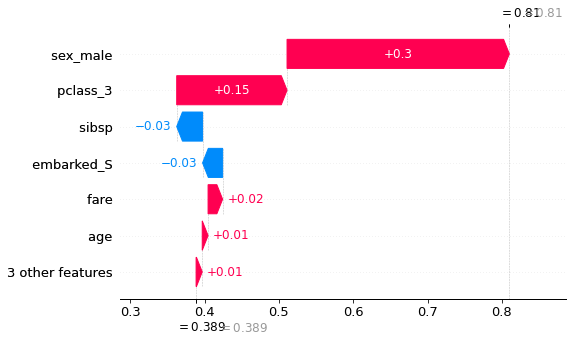

In [12]:
#Waterfall_plot for Rose
idx = 'Rose'
print(X_test.loc[idx])
shap_values = explainer.shap_values(X_test.loc[idx])
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]}.\nWaterfall plot of features contributions for class 1 (survived) :")
#shap.waterfall_plot(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)
waterfall_legacy(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)


## What about Jack?

Survived proba for Jack is 0.02.
Waterfall plot of features contributions for class 1 (survived) :


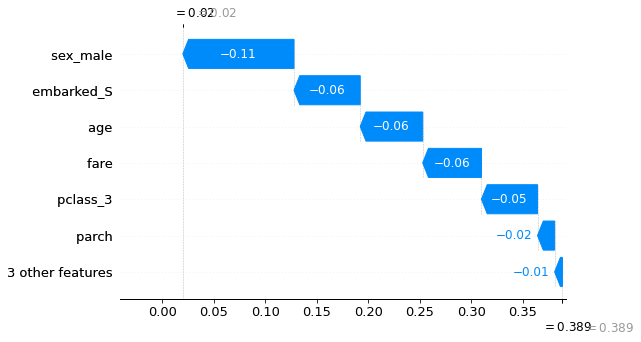

In [13]:
#Waterfall_plot for Jack
idx = 'Jack'
#print(df_test.loc[idx])
#shap_values = explainer.shap_values(X_test.loc[idx])
shap_values = explainer.shap_values(X_test.loc[idx], check_additivity=False)
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]}.\nWaterfall plot of features contributions for class 1 (survived) :")
#Try explanability with original values
#shap.waterfall_plot(explainer.expected_value[1], shap_values[1], df_test.loc[idx],max_display=max_display)
waterfall_legacy(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)

## What if Jack would be richer?
Jack would now travel in pclass 1 with an high fare ticket.

In [14]:
idx = 'Jack_Rich'
df_test.loc[idx]

age            20.0
sibsp           0.0
parch           0.0
fare          211.3
pclass_2        0.0
pclass_3        0.0
sex_male        1.0
embarked_Q      0.0
embarked_S      1.0
Name: Jack_Rich, dtype: float64

Survived proba for Jack_Rich is 0.09.
Waterfall plot of features contributions for class 1 (survived) :


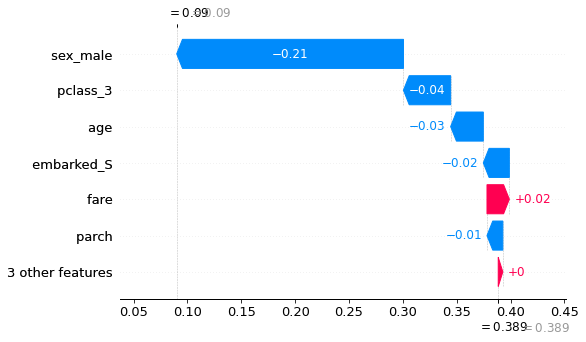

In [15]:
#Waterfall_plot 
shap_values = explainer.shap_values(X_test.loc[idx])
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]:.2}.\nWaterfall plot of features contributions for class 1 (survived) :")
#Try explanability with original values
#shap.waterfall_plot(explainer.expected_value[1], shap_values[1], df_test.loc[idx],max_display=max_display)
waterfall_legacy(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)

## If Jack was a litle boy?
Jack is now a litle boy (5 years old) travelling with his mother (parch=1) in class 3.

In [16]:
idx = 'Jack_Boy'
df_test.loc[idx]

age           5.0
sibsp         0.0
parch         1.0
fare          9.5
pclass_2      0.0
pclass_3      1.0
sex_male      1.0
embarked_Q    0.0
embarked_S    1.0
Name: Jack_Boy, dtype: float64

Survived proba for Jack_Boy is 0.92.
Waterfall plot of features contributions for class 1 (survived) :


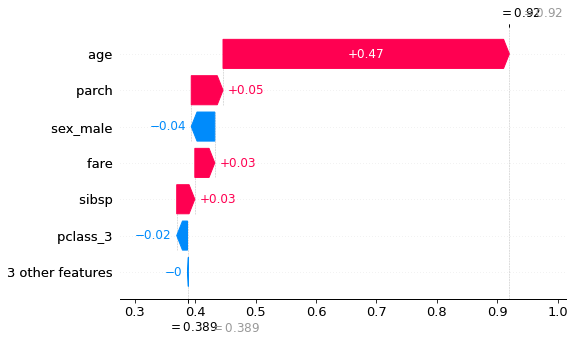

In [17]:
#Waterfall_plot
shap_values = explainer.shap_values(X_test.loc[idx])
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]:.2}.\nWaterfall plot of features contributions for class 1 (survived) :")
#Try explanability with original values
#shap.waterfall_plot(explainer.expected_value[1], shap_values[1], df_test.loc[idx],max_display=max_display)
waterfall_legacy(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)